In [1]:
import gym
from scipy.special import expit as sigmoid
import numpy as np
import numpy.random as npr
import time
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
from a2c_ppo_acktr import utils
import random

from heap import Heap

In [2]:
class args(object):
    bandwidth = 3
    postwidth = 3
    threshold = 0.1
    slip_reward = -0.001
    signal_split = 1
    fps = 3
    log_interval = 250
    use_gae = False
    num_updates = 1e5
    num_steps = 10
    sleep_freq = 0
    sleep_skip = False
    memory_capacity = num_steps*fps*13
    ppo_epoch = 1
    num_mini_batch = 10
    value_loss_coef = 0.5
    entropy_coef = 0.01
    lr = 1e-1
    eps = 1e-5
    max_grad_norm = 0.01
    clip_param = 0.01
    gamma = 0.99
    gae_lambda = 0.95
    use_proper_time_limits = False

In [3]:
env = gym.make('CartPole-v0')
heap = Heap(13, 4, 1, args=args)

/home/f1ery/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
episode_rewards = deque(maxlen=args.log_interval)
episode_relaxes = deque(maxlen=args.log_interval)
done = True

for j in count(1):
    heap.clear_memory()
    if done:
        state = env.reset()
        episode_rewards.append(0)
        episode_relaxes.append(0)
    for unit in heap.units:
        utils.update_linear_schedule(unit.agent.optimizer, j, args.num_updates, args.lr)
    for step in range(args.num_steps):
        if args.sleep_freq and episode_rewards[-1] % args.sleep_freq == 0 and episode_rewards[-1]:
            heap.sleep(skip=args.sleep_skip)
        action, zeros_mask = heap(state, n=args.fps)
        action = int(action > 0.5)
        if len(zeros_mask[0]):
            if state[2] > 0:
                action = 0
            else:
                action = 1
        state, reward, done, info = env.step(action)
        heap.reward(reward)
        episode_rewards[-1] += reward
        if done:
            heap.done()
        if len(zeros_mask[0]) and reward:
            episode_relaxes[-1] += 1
    heap.update()
    if j % args.log_interval == 0:
        print('Iter: %d, Avg/Max/Min. reward: %0.1f/%0.1f/%0.1f, Avg relaxation: %0.2f' % (j, sum(episode_rewards)/len(episode_rewards), max(episode_rewards), min(episode_rewards), sum(episode_relaxes)/sum(episode_rewards)))

/home/f1ery/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Iter: 250, Avg/Max/Min. reward: 9.5/26.0/8.0, Avg relaxation: 0.88
Iter: 500, Avg/Max/Min. reward: 8.8/12.0/8.0, Avg relaxation: 0.99
Iter: 750, Avg/Max/Min. reward: 8.8/11.0/8.0, Avg relaxation: 1.00
Iter: 1000, Avg/Max/Min. reward: 8.7/10.0/8.0, Avg relaxation: 1.00
Iter: 1250, Avg/Max/Min. reward: 8.8/11.0/8.0, Avg relaxation: 1.00
Iter: 1500, Avg/Max/Min. reward: 8.8/11.0/8.0, Avg relaxation: 1.00
Iter: 1750, Avg/Max/Min. reward: 8.7/10.0/8.0, Avg relaxation: 1.00
Iter: 2000, Avg/Max/Min. reward: 8.8/10.0/8.0, Avg relaxation: 1.00
Iter: 2250, Avg/Max/Min. reward: 8.7/10.0/8.0, Avg relaxation: 1.00
Iter: 2500, Avg/Max/Min. reward: 8.7/11.0/8.0, Avg relaxation: 1.00
Iter: 2750, Avg/Max/Min. reward: 8.7/11.0/8.0, Avg relaxation: 1.00


KeyboardInterrupt: 

INPUTS


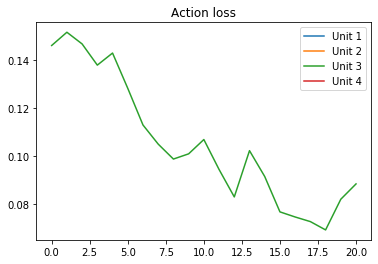

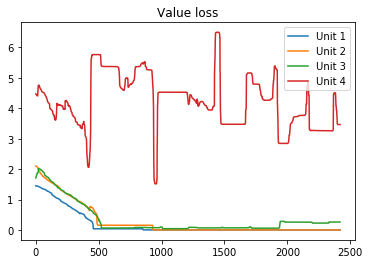

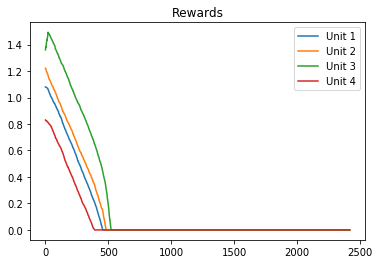

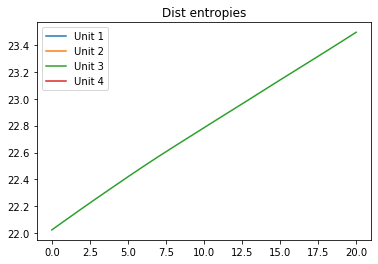

HIDDEN


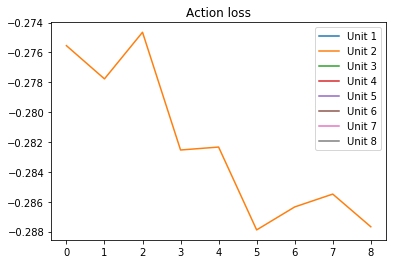

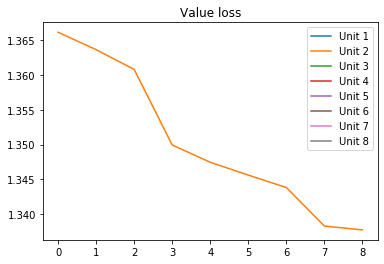

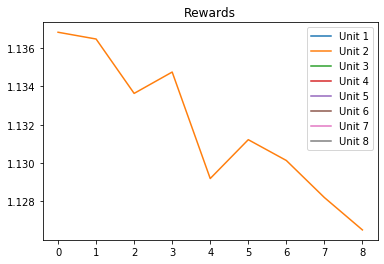

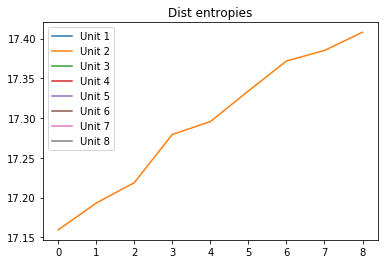

OUTPUTS


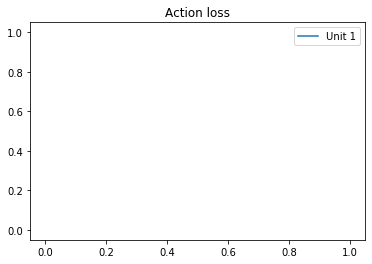

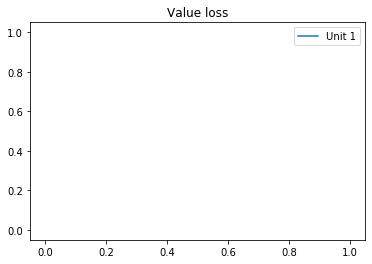

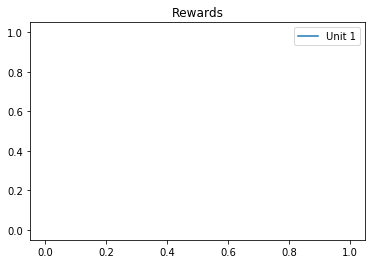

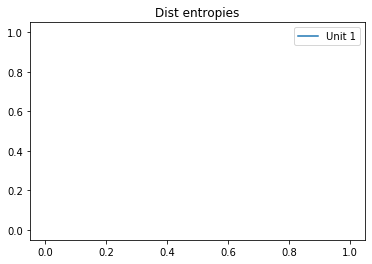

In [5]:
heap.plot_stats(n=500)